# This section contains Imports to the code

In [1]:
from keras import backend as K # to make sure keras code is compatible with both tensorflow and theano
import time # Make log of your codes running time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) # Set a constant seed to make sure your results are reproducible and the same random numbers are generated each time
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


# The codes cells below contain initialization of labels and plotting sample images


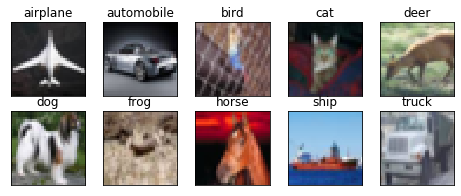

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3)) # the width and height(8,3) is in inches
num_classes = len(class_names)
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[]) # nrows,ncols,index of the axes
    idx = np.where(train_labels[:]==i)[0] # Get the indices of all images with label i and select only the rows indices
    # idx is list of indices of all the images with label i
    features_idx = train_features[idx,::] # Select all those images
    img_num = np.random.randint(features_idx.shape[0]) # Get a random image from those images
    im = features_idx[img_num] 
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# The two code cells below contain two functions.  One to plot model history and another one to plot the acccuracy

In [0]:
def plot_model_history(model_history):
    '''
      This function plots 2 graphs
      The first one plots the models training_acc vs validation accuracy
      The second one plots the models training loss vs validation loss
    '''
    fig, axs = plt.subplots(1,2,figsize=(15,5)) # 2 plots
    # summarize history for accuracy
    # In the below line of code, the x axis is range function which gives a list of number of epochs and y axis is the accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    '''
        This function just gets the accuracy of the model for test dataset 
    '''
    result = model.predict(test_x)
    # axis=1 means, select the max as per the colums and give their index
    predicted_class = np.argmax(result, axis=1)
    # both result and test_y are of the shape (num_test,10) so the same thing works on both of them
    true_class = np.argmax(test_y, axis=1)
    # Will take the true values as 1 and false values as 0 and then sum them up
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Image normaliztion and one hot encoding of labels`

In [0]:
# Image normalization
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Training the model
-Base Model gave an accuracy of around 82.60%

In [0]:
def trainModel(model,epochs=25):
  from keras.preprocessing.image import ImageDataGenerator
  # This is for me to change and mess around with
  datagen = ImageDataGenerator(zoom_range=0.0, 
                              horizontal_flip=False)
  
  
  # train the model
  start = time.time()
  
  # Train the model
  model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                  samples_per_epoch = train_features.shape[0], nb_epoch = epochs, 
                                  validation_data = (test_features, test_labels), verbose=1)
  end = time.time()
  print ("Model took %0.2f seconds to train"%(end - start))
  # plot model history
  plot_model_history(model_info)
  # compute test accuracy
  print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

# Adding Cutout to Assignment 6A COde

Building the modified model with:
  - Removed Dense Layers and added Global Average Pooling layers.
  - Adjusted the Receptive Field

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

def trainModel(model,epochs=25):
  from keras.preprocessing.image import ImageDataGenerator
  # This is for me to change and mess around with
  datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function=get_random_eraser(v_l=0, v_h=1),horizontal_flip=False)
  
  
  # train the model
  start = time.time()
  
  # Train the model
  model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                  samples_per_epoch = train_features.shape[0], nb_epoch = epochs, 
                                  validation_data = (test_features, test_labels), verbose=1)
  end = time.time()
  print ("Model took %0.2f seconds to train"%(end - start))
  # plot model history
  plot_model_history(model_info)
  # compute test accuracy
  print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


In [0]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras import optimizers
def ModifiedModel():
    model = Sequential()
    model.add(Convolution2D(32,3,3, border_mode='same', input_shape=(32,32,3))) # 32, 3
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(64,3,3,border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Convolution2D(32,3,3,border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D((2,2))) # 16, 10
    model.add(Dropout(0.25))

    model.add(Convolution2D(32,3,3,border_mode='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(64,3,3,border_mode='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(128,3,3,border_mode='same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D((2,2))) # 16, 10
    model.add(Dropout(0.25))

    model.add(Convolution2D(32,3,3, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(64,3,3,border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(128,3,3,border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Convolution2D(10,(8,8)))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to th

Epoch 1/30
390/390 [==============================] - 12s 30ms/step - loss: 1.9535 - acc: 0.3202 - val_loss: 1.9535 - val_acc: 0.3675
Epoch 2/30
390/390 [==============================] - 10s 25ms/step - loss: 1.3353 - acc: 0.5215 - val_loss: 1.2678 - val_acc: 0.5474
Epoch 3/30
390/390 [==============================] - 10s 25ms/step - loss: 1.0568 - acc: 0.6252 - val_loss: 1.2501 - val_acc: 0.5805
Epoch 4/30
390/390 [==============================] - 10s 25ms/step - loss: 0.9129 - acc: 0.6773 - val_loss: 1.0041 - val_acc: 0.6729
Epoch 5/30
390/390 [==============================] - 10s 25ms/step - loss: 0.8187 - acc: 0.7114 - val_loss: 0.8865 - val_acc: 0.6927
Epoch 6/30
390/390 [==============================] - 10s 25ms/step - loss: 0.7541 - acc: 0.7340 - val_loss: 0.9899 - val_acc: 0.6849
Epoch 7/30
390/390 [==============================] - 10s 25ms/step - loss: 0.6937 - acc: 0.7551 - val_loss: 0.6487 - val_acc: 0.7765
Epoch 8/30
390/390 [==============================] - 10s 25ms

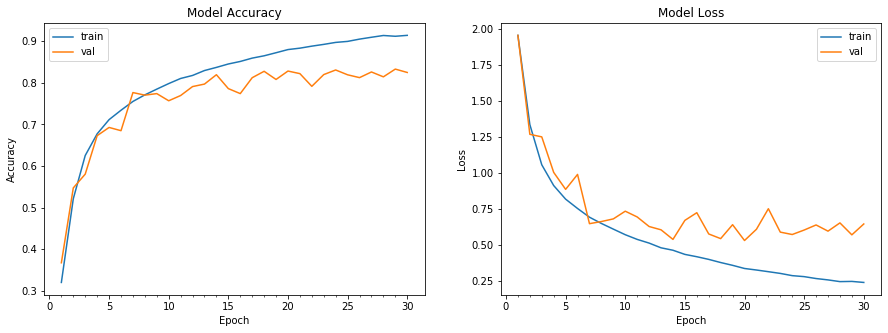

Accuracy on test data is: 82.48


In [86]:
model = ModifiedModel()
#model.summary()
trainModel(model,epochs=30)

# Assignment 9B with Cutout


### Choosing an Image

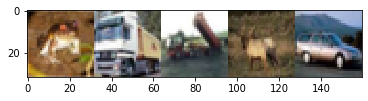

In [88]:
image = train_features[0:5]
plt.imshow(np.hstack(image))

### Build GradCAM

In [0]:
def plot_grad_cam(model, last_conv_layer, image):
    class_idx = np.argmax(model.predict(image)[0])
    class_output = model.output[:,class_idx]
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    pooled_grads, last_conv_layer_output = iterate([image])
    for i in range(pooled_grads.shape[0]):
        last_conv_layer_output[:,:,i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    heatmap = cv2.resize(heatmap, (image.shape[1],image.shape[2]))
    fig,ax = plt.subplots(1,2)
    
    ax[0].imshow(image[0])
    
    ax[1].imshow(image[0],alpha=0.9)
    ax[1].imshow(heatmap,alpha=0.6)

### Plotting Grad CAM

In [0]:
last_conv_layer = model.get_layer("conv2d_19")

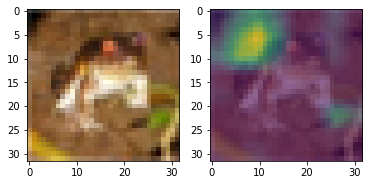

In [108]:
plot_grad_cam(model, last_conv_layer, image[0][np.newaxis,:])

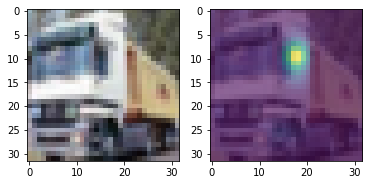

In [109]:

plot_grad_cam(model, last_conv_layer, image[1][np.newaxis,:])

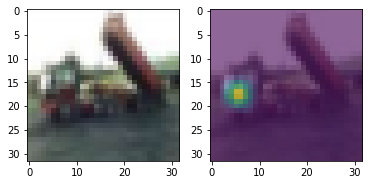

In [110]:

plot_grad_cam(model, last_conv_layer, image[2][np.newaxis,:])

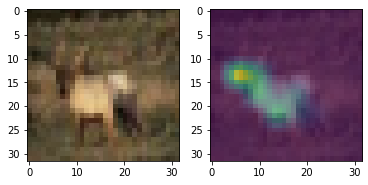

In [111]:

plot_grad_cam(model, last_conv_layer, image[3][np.newaxis,:])

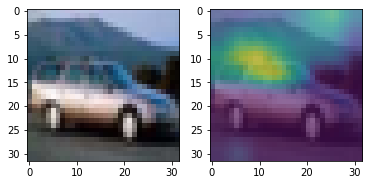

In [112]:

plot_grad_cam(model, last_conv_layer, image[4][np.newaxis,:])